In [ ]:
# this is if you want to run the notebook on google colab

# ! git  clone -b bear-face-automatic-annotation --single-branch  https://gitlab.com/fruitpunch/projects/ai-for-bears/face-detection-and-segmentation/albear.git
# ! git clone https://github.com/IDEA-Research/GroundingDINO.git

# # !nvcc --version
# # !which nvcc
# %env CUDA_HOME=/usr/local/cuda

# ! cd GroundingDINO && pip install -e .

# # you need to restart the runtime for the installation to be succesful

In [1]:
import glob
import sys
from tqdm import tqdm
from PIL import Image
from os import path
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import csv
import random
import pandas as pd
import math

/var/folders/n9/8dr8vdcj2dl7rvt8y69nxd880000gn/T/ipykernel_76055/1591411087.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
from multiprocessing import Process, Queue, cpu_count
print(f'{cpu_count()} cpus')
import groundingdino

sys.path.append('../../src/bearfacelabeling')
import predict

In [2]:
input_dir = '../../data/01_raw/Hack the Planet'
sub_dirs = [
    '../../data/01_raw/Hack the Planet/images/Bison - bears only',
    '../../data/01_raw/Hack the Planet/images/Season1 -  bears only',
    '../../data/01_raw/Hack the Planet/images/Season2 - bears only',
    '../../data/01_raw/Hack the Planet/images/Season3 - bears only',
    '../../data/01_raw/Hack the Planet/images/Season5 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/BearFeedingPoints - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Bison - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season1 -  bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season2 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season3 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season5 - bears only'
]
output_dir = '../../data/07_model_output/bearfacelabeling/Hack the Planet'

In [3]:
image_extensions = [".jpg", ".PNG", ".JPG"]
image_paths = [ path for folder in sub_dirs for ext in image_extensions for path in glob.iglob('%s/**/*%s' % (folder, ext), recursive=True)]

# Path(output_dir).mkdir(parents=True, exist_ok=True)
# with open(path.join(output_dir, 'list_of_images.csv'), 'w') as f:
#     writer = csv.writer(f)
#     for p in image_paths:
#         rel_p = path.relpath(p, input_dir)
#         writer.writerow([rel_p])

#import pickle
# with open('list_of_images', 'wb') as fp:
#     pickle.dump(image_paths, fp)

# import pickle
# with open ('list_of_images', 'rb') as fp:
#     image_paths = pickle.load(fp)


print(len(image_paths))

16485


In [ ]:
model_checkpoint_path = '/content/drive/MyDrive/FruitPunch AI/groundingdino_swint_ogc.pth'
model = predict.Model(model_checkpoint_path, device = 'cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Generate annotations

In [ ]:
for image_path in tqdm_notebook(image_paths):
  image = Image.open(image_path)
  bbox = model.predict(image)

  relative_image_path = path.relpath(image_path, input_dir)
  relative_ann_path = path.splitext(relative_image_path)[0] + '.txt'
  ann_path = path.join(output_dir, relative_ann_path)
  Path(path.dirname(ann_path)).mkdir(parents=True, exist_ok=True)

  with open(ann_path, 'w') as f:
    writer = csv.writer(f)
    if bbox:
        f.write_row([0] + bbox)

744


## Generate annotations using multiprocessing to load images
(in google colab loading images is a bottleneck)

In [60]:
def worker(input, output):
    for path in iter(input.get, 'STOP'):
      image = Image.open(path)
      output.put((path, image))

task_queue = Queue()
image_queue = Queue(maxsize = 20)

number_of_processes = 6

for p in image_paths:
  task_queue.put(p)

for i in range(number_of_processes):
  task_queue.put('STOP')

for i in range(number_of_processes):
  Process(target=worker, args=(task_queue, image_queue)).start()

# i need to load three images in parallel

n_stops = 0

# todo: list the paths that are not succesful
succesful_paths = []

for image_path in tqdm_notebook(image_paths):
  result = output.get()

  n_stops += int(result == 'STOP')
  if n_stops >= number_of_processes:
    break

  image_path, image = image_queue.get()
  bbox = model.predict(image)

  relative_image_path = path.relpath(image_path, input_dir)
  relative_ann_path = path.splitext(relative_image_path)[0] + '.txt'
  ann_path = path.join(output_dir, relative_ann_path)
  Path(path.dirname(ann_path)).mkdir(parents=True, exist_ok=True)

  succesful_paths.append(image_path)

  with open(ann_path, 'w') as f:
    if bbox:
        f.write(' '.join(str(v) for v in [0] + bbox))


NameError: name 'Queue' is not defined

## Visualize

In [4]:
def display_pred(bb_data, ax):
    bb = bb_data[0]
    style = bb_data[1]
    rect = patches.Rectangle(
        (bb[0], bb[1]),
        bb[2],
        bb[3],
        linewidth=2,
        facecolor='none',
        **style
    )
    ax.add_patch(rect)
    return ax

def display_image_data(image, bboxes_data, ax):
    ax.imshow(image)
    for bb_data in bboxes_data:
        display_pred(bb_data, ax)

def display_entry(entry, ax):
    image_path = path.join(input_dir, entry.img if isinstance(entry, pd.Series) else entry)
    image = Image.open(image_path)
    # print(entry)
    bbox = None

    if isinstance(entry, pd.Series) and 'bbox' in entry.index:
        bbox_v8 = entry.bbox
        image = Image.open(image_path)
        w,h = image.size

        bb_w, bb_h = bbox_v8[2]*w, bbox_v8[3]*h
        bbox = [bbox_v8[0]*w - bb_w/2, bbox_v8[1]*h - bb_h/2, bb_w, bb_h ]

    display_image_data(image,
        [(bbox,{'edgecolor': 'g'})] if bbox else []
        , ax)

def display_entries(entries, ncols = 1, figsize=10):
    fig, ax = plt.subplots(math.ceil(len(entries)/ncols), ncols, figsize=(figsize,figsize))
    ax = ax.flatten()
    for i in range(len(entries)):
        display_entry(entries.iloc[i],ax[i])
        ax[i].axis('off') 
    plt.tight_layout()
    plt.show()

In [8]:
# load the annotations
anns = {}
imgs_without_ann_file = []
for img_path in image_paths:
    img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
    ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'
    try:
        with open(path.join(output_dir, ann_rel_path), 'r') as f_ann:
            reader_ann = csv.reader(f_ann)
            lines = [row for row in reader_ann]
            anns[img_rel_path] = [float(v) for v in lines[0][1:]] if lines else None
    except FileNotFoundError as err:
        imgs_without_ann_file.append(img_rel_path)



df = pd.DataFrame.from_dict({'img': anns.keys(), 'bbox':anns.values()})

df_no_annotation = df[df['bbox'].isna()]['img']
df_annotated = df.dropna()
df_image_pb = pd.DataFrame.from_dict({'img': imgs_without_ann_file})

print(df_annotated.shape)
print(df_no_annotation.shape)
print(df_image_pb.shape)
print(len(image_paths))

(14274, 2)
(1345,)
(866, 1)
16485


### images with bbox

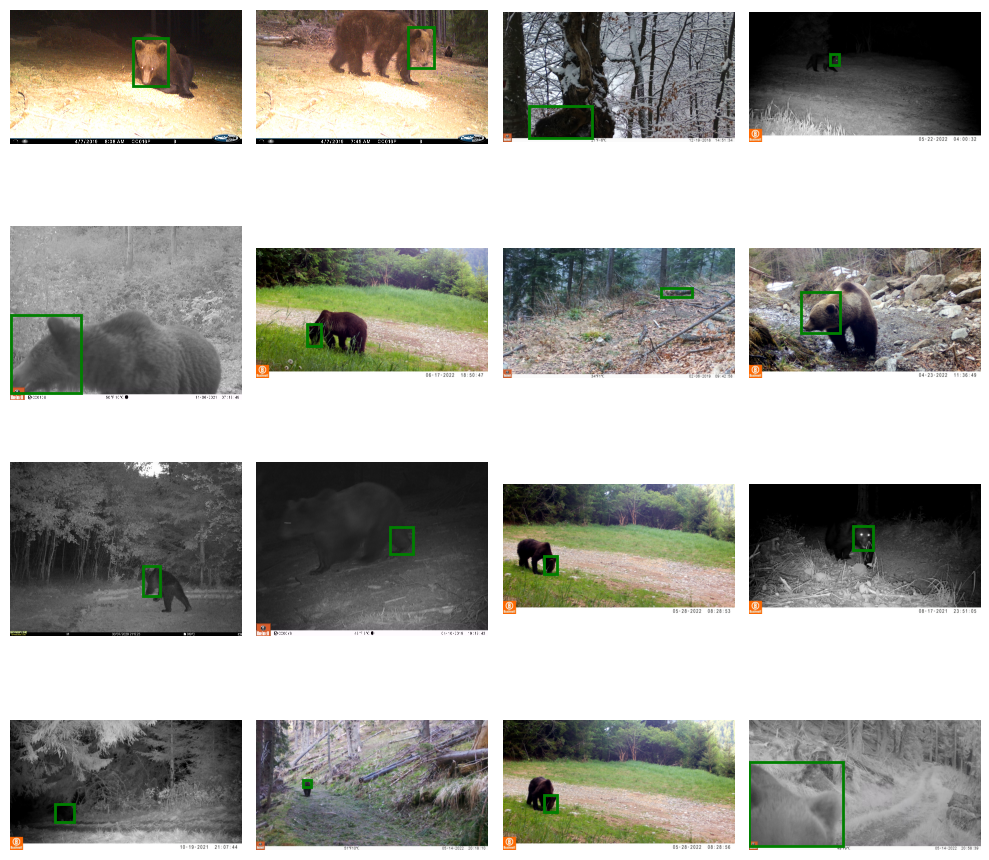

In [110]:
display_entries(df_annotated.sample(n=16), ncols=4)

### Images without bbox

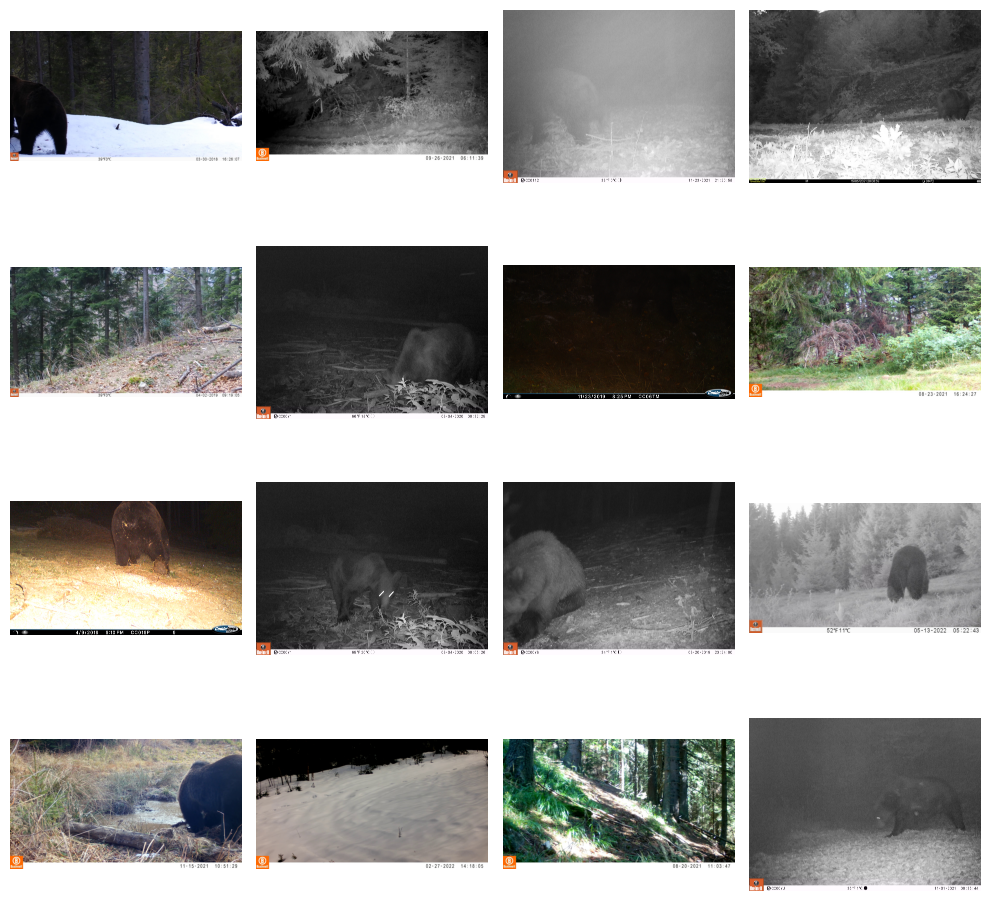

In [10]:
display_entries(df_no_annotation.sample(n=16), ncols=4)

### Truncated images

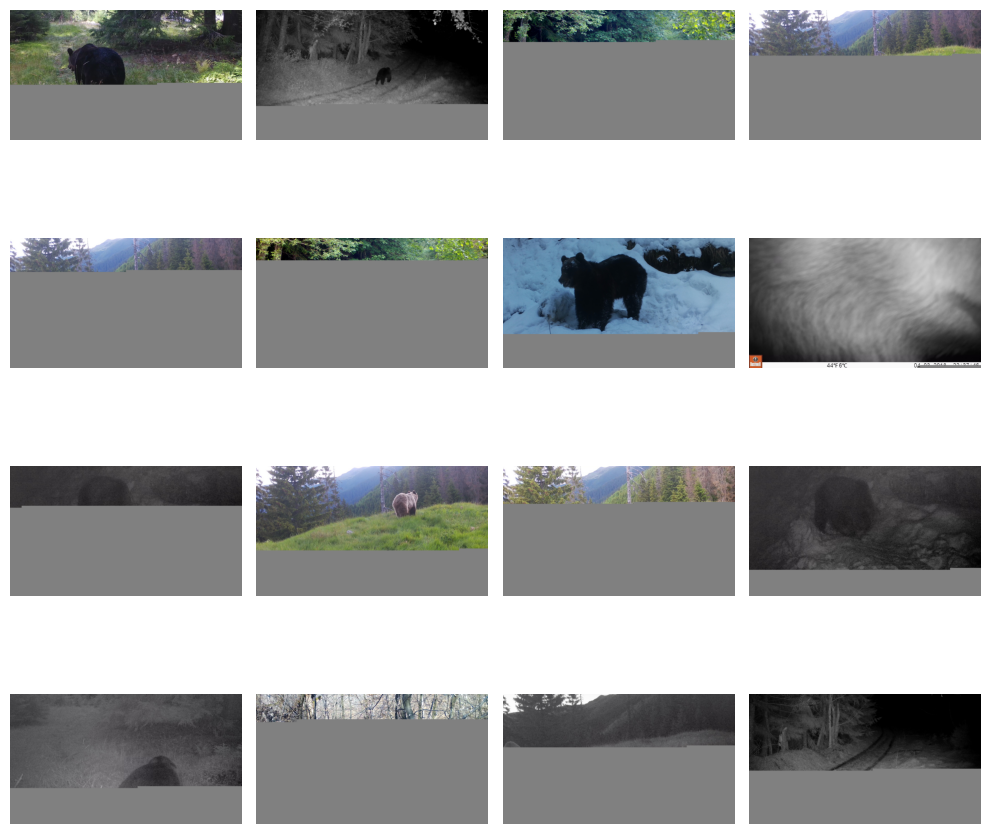

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
display_entries(df_image_pb.sample(n=16), ncols=4)

In [29]:
imgs_without_ann_file = []
for img_path in image_paths:
    img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
    ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'
    ann_path = path.join(output_dir, ann_rel_path)
    other_ann_path = path.join(output_dir, 'fixed', ann_rel_path)
    Path(path.dirname(other_ann_path)).mkdir(parents=True, exist_ok=True)
    
    try:
        with open(ann_path, 'r') as f_ann:
            reader_ann = csv.reader(f_ann)
            lines = [row for row in reader_ann]
            numeric_values = [float(v) for v in lines[0][0].split(' ')] if lines else []
            with open(other_ann_path, 'w') as f_other_ann:
                writer = csv.writer(f_other_ann)
                if numeric_values:
                    writer.writerow(numeric_values)        
    except FileNotFoundError as err:
        imgs_without_ann_file.append(img_path)